## Neural Style Transfer

This code implement a neural algorithm of artistic style based on the original paper by Gatys et al. 

In [1]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models


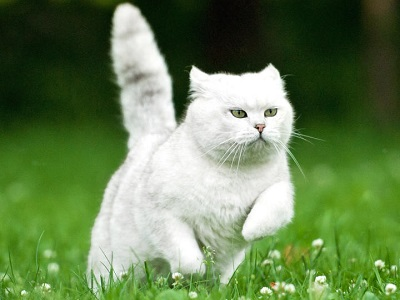

In [2]:
c = 'cat.jpg'
Image.open((f'png/{c}'))

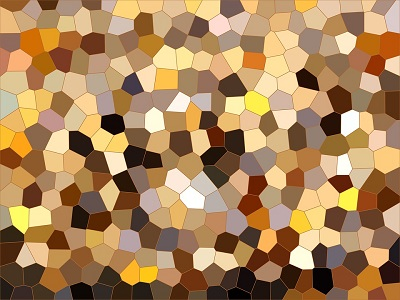

In [3]:
s = 'mosaic.jpg'
Image.open((f'png/{s}'))

In [4]:
# the function get image path, and return a tensor with shape (1,c,h,w) ready and normelize for vgg19 net.
def load_image(img_path, max_size=300):

    image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    in_transform = transforms.Compose([
        transforms.Resize((size, int(1.5*size))),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

    image = in_transform(image).unsqueeze(0)

    return image

In [5]:
# the function get image tensor and return the basic image.
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array(
        (0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    image = image * 255
    image = np.uint8(np.rint(image))
    return Image.fromarray(image)

In [6]:
# The algorithem use the intermediate features of the model.
# So this function is like the "forward" function, get an image and the model and return the results
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1', '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content layer
                  '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in enumerate(model.features):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x

    return features

In [7]:
# part of the loss
def gram_matrix(tensor):
    _, n_filters, h, w = tensor.size()
    tensor = tensor.view(n_filters, h * w)
    gram = torch.mm(tensor, tensor.t())

    return gram

In [8]:
# The model is the pretrained vgg19. the model is freez so it's parameters not change at all!
# plus every maxpool layer changed to avgpool layer
vgg = models.vgg19()
vgg.load_state_dict(torch.load('vgg19-dcbb9e9d.pth'))

for param in vgg.parameters():
  param.requires_grad_(False)


for i, layer in enumerate(vgg.features):
  if isinstance(layer, torch.nn.MaxPool2d):
    vgg.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device).eval()

content = load_image(f'png/{c}').to(device)
style = load_image(f'png/{s}').to(device)

In [9]:
# the style and normal image features are permanent so we calculate this only one time.
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [10]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features} # calculate the gram_matrix on the style features 

if the model parameters freeze and the style + contant image also permanent what we learn?

We initilize target image (total random, or copy of the content image) with requires_grad == True. and change this target image so it's distance to style image and content image will be small



In [11]:
#target = torch.randn_like(content).requires_grad_(True).to(device)  # random noise
target = content.clone().requires_grad_(True).to(device)  # content image

In [12]:
# Hyper parameters
style_weights = {'conv1_1': 0.75,
                'conv2_1': 0.5,
                'conv3_1': 0.2,
                'conv4_1': 0.2,
                'conv5_1': 0.2}
content_weight = 1e1
style_weight = 1e2
optimizer = optim.Adam([target], lr=0.01)
steps = 401

In [13]:
import time
start = time.time()
for i in range(1, steps):

    optimizer.zero_grad()
    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] -
                                       content_features['conv4_2']) ** 2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean(
            (target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    if i % 50 == 0:
        total_loss_rounded = round(total_loss.item(), 2)
        
        content_fraction = round(content_weight * content_loss.item() / total_loss.item(), 2)
        
        style_fraction = round(style_weight * style_loss.item() / total_loss.item(), 2)
        
        print('Iteration {}, Total loss: {} - (content: {}, style {})'.format(i, total_loss_rounded, content_fraction, style_fraction))
    
    
end = time.time()
print("total time: ", end - start)

Iteration 50, Total loss: 2012.59 - (content: 0.0, style 1.0)
Iteration 100, Total loss: 864.97 - (content: 0.01, style 0.99)
Iteration 150, Total loss: 541.29 - (content: 0.01, style 0.99)
Iteration 200, Total loss: 376.49 - (content: 0.02, style 0.98)
Iteration 250, Total loss: 278.89 - (content: 0.03, style 0.97)
Iteration 300, Total loss: 215.79 - (content: 0.05, style 0.95)
Iteration 350, Total loss: 172.53 - (content: 0.06, style 0.94)
Iteration 400, Total loss: 142.24 - (content: 0.07, style 0.93)
total time:  50.17199087142944


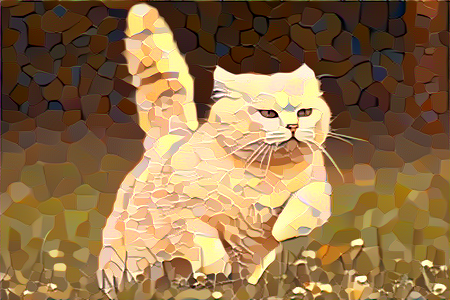

In [14]:
final_img = im_convert(target)
final_img